# CUPED (Controlled-experiment Using Pre-Existing Data)

## Overview:
- Uses pre-experiment data to reduce variance of the sample statistic
- Resulting in statistical tests requiring smaller sample size, holding all other power analysis inputs constant (i.e. power, significance level, MEI)
- CUPED method above only removes variance that can be accounted for linearly

Tutorial: https://www.datasciencecentral.com/cuped-for-starters-enhancing-controlled-experiments-with-pre-experiment-data/

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import pingouin as pg
import statsmodels.formula.api as smf

In [55]:
exp_data = pd.read_csv('./data/commission_revenue.csv')
exp_data.head()

,group,user_id,commission_revenue_pre,commission_revenue_exp
0,control,cf7f6389-95e8-44b1-88d9-71a784d0eea3,126.174822,131.495757
1,control,6b129f09-fb5f-42df-bde3-a0daf9476c31,95.278575,105.803968
2,test,f5ce5d40-a918-482f-bd4a-27ade2af0d97,101.397369,101.787418
3,control,82592e1a-b6b7-42bf-a625-1fc138f92d3e,68.855613,56.851970
4,control,549b14a8-fc08-4224-bf8e-931a7a50e6ff,112.974435,101.960805


In [56]:
exp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   group                   2000 non-null   object 
 1   user_id                 2000 non-null   object 
 2   commission_revenue_pre  1963 non-null   float64
 3   commission_revenue_exp  2000 non-null   float64
dtypes: float64(2), object(2)
memory usage: 62.6+ KB


In [57]:
exp_data['group'].value_counts()

group
control    1006
test        994
Name: count, dtype: int64

In [58]:
exp_data.describe()

,commission_revenue_pre,commission_revenue_exp
count,1963.000000,2000.000000
mean,99.698775,100.476971
std,31.334267,30.993815
min,17.609063,24.066707
25%,73.596740,74.589023
50%,99.355972,101.460640
75%,125.312077,125.606264
max,181.057306,183.795058


In [59]:
exp_data_control = exp_data[exp_data['group'] == 'control']
exp_data_test = exp_data[exp_data['group'] == 'test']

In [60]:
exp_data_control.describe()

,commission_revenue_pre,commission_revenue_exp
count,986.000000,1006.000000
mean,99.651352,99.236207
std,31.237388,30.352123
min,17.609063,31.699078
25%,73.637132,73.761569
50%,100.245799,101.207732
75%,125.152471,124.762612
max,172.324492,183.795058


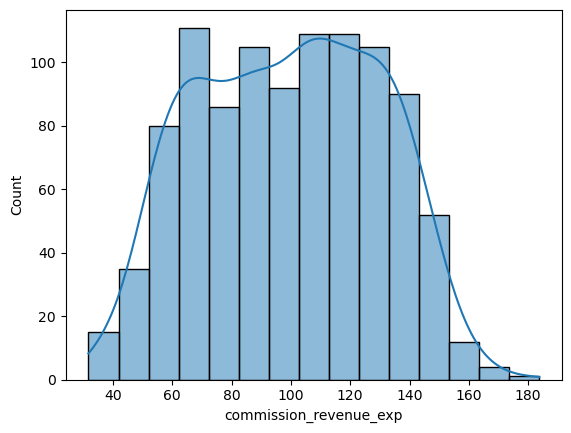

In [61]:
sns.histplot(exp_data_control['commission_revenue_exp'], kde=True);

In [62]:
exp_data_test.describe()

,commission_revenue_pre,commission_revenue_exp
count,977.000000,994.000000
mean,99.746634,101.732714
std,31.447663,31.595677
min,33.301479,24.066707
25%,73.341719,75.307873
50%,98.714688,101.870798
75%,125.544276,128.677889
max,181.057306,176.005057


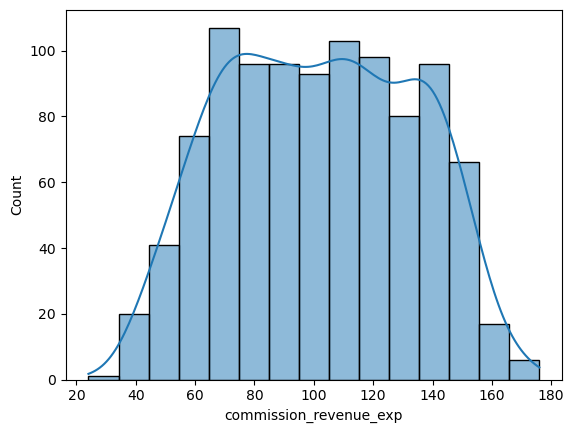

In [63]:
sns.histplot(exp_data_test['commission_revenue_exp'], kde=True);

---

## Summary Statistics: Test vs. Control

In [64]:
# experiment data
test_exp_mean = exp_data_test['commission_revenue_exp'].mean()
control_exp_mean = exp_data_control['commission_revenue_exp'].mean()
test_exp_var = np.var(exp_data_test['commission_revenue_exp'], ddof=1)
control_exp_var = np.var(exp_data_control['commission_revenue_exp'], ddof=1)
test_exp_std = np.std(exp_data_test['commission_revenue_exp'], ddof=1)
control_exp_std = np.std(exp_data_control['commission_revenue_exp'], ddof=1)

# pre-experiment data
test_pre_mean = exp_data_test['commission_revenue_pre'].mean()
control_pre_mean = exp_data_control['commission_revenue_pre'].mean()
test_pre_var = np.var(exp_data_test['commission_revenue_pre'], ddof=1)
control_pre_var = np.var(exp_data_control['commission_revenue_pre'], ddof=1)
test_pre_std = np.std(exp_data_test['commission_revenue_pre'], ddof=1)
control_pre_std = np.std(exp_data_control['commission_revenue_pre'], ddof=1)

print("=" * 60)
print("EXPERIMENT DATA SUMMARY")
print("=" * 60)

print("\n📊 EXPERIMENT PERIOD (commission_revenue_exp)")
print("-" * 60)
print(f"Test Group Mean:       {test_exp_mean:,.2f}")
print(f"Control Group Mean:    {control_exp_mean:,.2f}")
print(f"Difference:            {test_exp_mean - control_exp_mean:,.2f}")
print(f"Lift:                  {((test_exp_mean / control_exp_mean - 1) * 100):.2f}%")
print()
print(f"Test Group Std Dev:    {test_exp_std:,.2f}")
print(f"Control Group Std Dev: {control_exp_std:,.2f}")
print()
print(f"Test Group Variance:   {test_exp_var:,.2f}")
print(f"Control Group Variance:{control_exp_var:,.2f}")

print("\n📊 PRE-EXPERIMENT PERIOD (commission_revenue_pre)")
print("-" * 60)
print(f"Test Group Mean:       {test_pre_mean:,.2f}")
print(f"Control Group Mean:    {control_pre_mean:,.2f}")
print(f"Difference:            {test_pre_mean - control_pre_mean:,.2f}")
print()
print(f"Test Group Std Dev:    {test_pre_std:,.2f}")
print(f"Control Group Std Dev: {control_pre_std:,.2f}")
print()
print(f"Test Group Variance:   {test_pre_var:,.2f}")
print(f"Control Group Variance:{control_pre_var:,.2f}")
print("\n" + "=" * 60)

EXPERIMENT DATA SUMMARY

📊 EXPERIMENT PERIOD (commission_revenue_exp)
------------------------------------------------------------
Test Group Mean:       101.73
Control Group Mean:    99.24
Difference:            2.50
Lift:                  2.52%

Test Group Std Dev:    31.60
Control Group Std Dev: 30.35

Test Group Variance:   998.29
Control Group Variance:921.25

📊 PRE-EXPERIMENT PERIOD (commission_revenue_pre)
------------------------------------------------------------
Test Group Mean:       99.75
Control Group Mean:    99.65
Difference:            0.10

Test Group Std Dev:    31.45
Control Group Std Dev: 31.24

Test Group Variance:   988.96
Control Group Variance:975.77



In [66]:
# check correlation between pre-experiment and experiment data for each group
from scipy.stats import pearsonr

# Drop missing values for TEST group
test_clean = exp_data_test[['commission_revenue_pre', 'commission_revenue_exp']].dropna()
test_corr, test_p_value = pearsonr(
    test_clean['commission_revenue_pre'], 
    test_clean['commission_revenue_exp']
)

# Drop missing values for CONTROL group
control_clean = exp_data_control[['commission_revenue_pre', 'commission_revenue_exp']].dropna()
control_corr, control_p_value = pearsonr(
    control_clean['commission_revenue_pre'], 
    control_clean['commission_revenue_exp']
)

# Print results
print("=" * 70)
print("PEARSON CORRELATION: Pre-Period vs Experiment Period")
print("=" * 70)
print("\n📈 TEST GROUP")
print("-" * 70)
print(f"Correlation:  {test_corr:>7.4f}")
print(f"P-value:      {test_p_value:>7.4f}")
print(f"Significant:  {'Yes ✓' if test_p_value < 0.05 else 'No ✗'}")
print("\n📉 CONTROL GROUP")
print("-" * 70)
print(f"Correlation:  {control_corr:>7.4f}")
print(f"P-value:      {control_p_value:>7.4f}")
print(f"Significant:  {'Yes ✓' if control_p_value < 0.05 else 'No ✗'}")
print("=" * 70)

PEARSON CORRELATION: Pre-Period vs Experiment Period

📈 TEST GROUP
----------------------------------------------------------------------
Correlation:   0.8955
P-value:       0.0000
Significant:  Yes ✓

📉 CONTROL GROUP
----------------------------------------------------------------------
Correlation:   0.8831
P-value:       0.0000
Significant:  Yes ✓


---

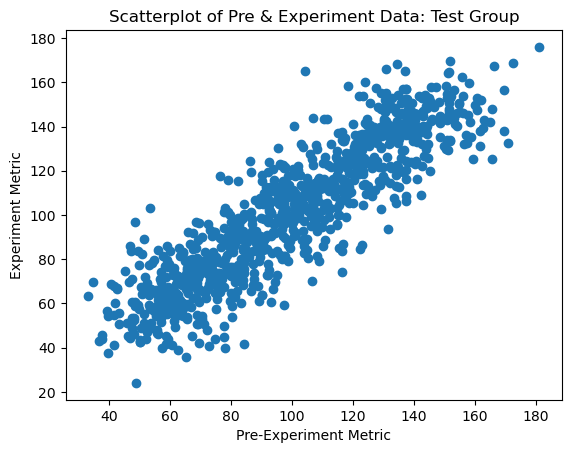

In [90]:
plt.scatter(test_clean['commission_revenue_pre'], test_clean['commission_revenue_exp']);
plt.title('Scatterplot of Pre & Experiment Data: Test Group')
plt.xlabel('Pre-Experiment Metric')
plt.ylabel('Experiment Metric')
plt.show();

## Statistical Test: Before CUPED Adjustment

In [53]:
# check if variances equal
pg.homoscedasticity(dv = "commission_revenue_exp",
                    group = "group",
                    method = "bartlett",
                    data = exp_data)

,T,pval,equal_var
bartlett,1.322457,0.250152,True


In [54]:
# perform t-tests on experiment data, no variance correction
pg.ttest(exp_data_test['commission_revenue_exp'], exp_data_control['commission_revenue_exp'],
         correction = False).transpose()

,T-test
T,1.653342
dof,1961
alternative,two-sided
p-val,0.098421
CI95%,"[-0.43, 5.07]"
cohen-d,0.074634
BF10,0.197
power,0.379409


---
Interpretation:
* p-value > 0.05 suggests that the mean revenue is not statistically different between test and control
---

## CUPED Adjusted Metrc: Y_adjusted

The adjustment formula: `Y_adjusted = Y - θ(X - X̄)` reduces variance by removing the predictable component based on pre-period behavior.

In [74]:
not_null_pre = ~exp_data['commission_revenue_pre'].isna()
cov_X_Y = np.cov(exp_data[not_null_pre]['commission_revenue_pre'], 
                 exp_data[not_null_pre]['commission_revenue_exp'],
                 ddof=1)[0, 1]
var_X = np.var(exp_data[not_null_pre]['commission_revenue_pre'], ddof=1)
corr_X_Y = np.corrcoef([exp_data[not_null_pre]['commission_revenue_pre'], 
                        exp_data[not_null_pre]['commission_revenue_exp']])[0,1]
theta = cov_X_Y / var_X

# Print results
print("=" * 70)
print("CUPED CALCULATION COMPONENTS")
print("=" * 70)
print(f"\nCovariance (X, Y):     {cov_X_Y:>15,.4f}")
print(f"Variance (X):          {var_X:>15,.4f}")
print(f"Correlation (X, Y):    {corr_X_Y:>15,.4f}")
print(f"Theta (θ):             {theta:>15,.4f}")
print(f"\nSample size (valid):   {not_null_pre.sum():>15,}")
print("=" * 70)

CUPED CALCULATION COMPONENTS

Covariance (X, Y):            865.8128
Variance (X):                 981.8363
Correlation (X, Y):             0.8887
Theta (θ):                      0.8818

Sample size (valid):             1,963


In [75]:
# calculate Y_adjusted : 'commission_revenue_exp_cuped'
    # for new users with no pre-experiment data, just use experiment data
exp_data['commission_revenue_exp_cuped'] = np.where(
    not_null_pre,
    exp_data['commission_revenue_exp'] - theta * (
        exp_data['commission_revenue_pre'] - exp_data['commission_revenue_pre'].mean()
    ),
    exp_data['commission_revenue_exp']
)

exp_data.head()

,group,user_id,commission_revenue_pre,commission_revenue_exp,commission_revenue_exp_cuped
0,control,cf7f6389-95e8-44b1-88d9-71a784d0eea3,126.174822,131.495757,108.148383
1,control,6b129f09-fb5f-42df-bde3-a0daf9476c31,95.278575,105.803968,109.701832
2,test,f5ce5d40-a918-482f-bd4a-27ade2af0d97,101.397369,101.787418,100.289546
3,control,82592e1a-b6b7-42bf-a625-1fc138f92d3e,68.855613,56.851970,84.050396
4,control,549b14a8-fc08-4224-bf8e-931a7a50e6ff,112.974435,101.960805,90.253929


---

## Original vs CUPED-Adjusted Metrics

In [81]:
print("=" * 80)
print("COMPARISON: Original vs CUPED-Adjusted Metrics")
print("=" * 80)

print("\n📊 TEST GROUP")
print("-" * 80)
print(f"{'Metric':<30} {'Original':<20} {'CUPED-Adjusted':<20}")
print("-" * 80)
print(f"{'Mean':<30} {exp_data[exp_data['group'] == 'test']['commission_revenue_exp'].mean():>19,.2f} {exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'].mean():>19,.2f}")
print(f"{'Variance':<30} {np.var(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], ddof=1):>19,.2f} {np.var(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], ddof=1):>19,.2f}")
print(f"{'Std Deviation':<30} {np.std(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], ddof=1):>19,.2f} {np.std(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], ddof=1):>19,.2f}")

print("\n📊 CONTROL GROUP")
print("-" * 80)
print(f"{'Metric':<30} {'Original':<20} {'CUPED-Adjusted':<20}")
print("-" * 80)
print(f"{'Mean':<30} {exp_data[exp_data['group'] == 'control']['commission_revenue_exp'].mean():>19,.2f} {exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped'].mean():>19,.2f}")
print(f"{'Variance':<30} {np.var(exp_data[exp_data['group'] == 'control']['commission_revenue_exp'], ddof=1):>19,.2f} {np.var(exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped'], ddof=1):>19,.2f}")
print(f"{'Std Deviation':<30} {np.std(exp_data[exp_data['group'] == 'control']['commission_revenue_exp'], ddof=1):>19,.2f} {np.std(exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped'], ddof=1):>19,.2f}")

print("\n📈 VARIANCE REDUCTION")
print("-" * 80)
test_var_reduction = (1 - np.var(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], ddof=1) / 
                      np.var(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], ddof=1)) * 100
control_var_reduction = (1 - np.var(exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped'], ddof=1) / 
                         np.var(exp_data[exp_data['group'] == 'control']['commission_revenue_exp'], ddof=1)) * 100

print(f"Test Group:     {test_var_reduction:>6.2f}% reduction")
print(f"Control Group:  {control_var_reduction:>6.2f}% reduction")
print("=" * 80)

COMPARISON: Original vs CUPED-Adjusted Metrics

📊 TEST GROUP
--------------------------------------------------------------------------------
Metric                         Original             CUPED-Adjusted      
--------------------------------------------------------------------------------
Mean                                        101.73              101.69
Variance                                    998.29              209.34
Std Deviation                                31.60               14.47

📊 CONTROL GROUP
--------------------------------------------------------------------------------
Metric                         Original             CUPED-Adjusted      
--------------------------------------------------------------------------------
Mean                                         99.24               99.28
Variance                                    921.25              210.45
Std Deviation                                30.35               14.51

📈 VARIANCE REDUCTION
----

---

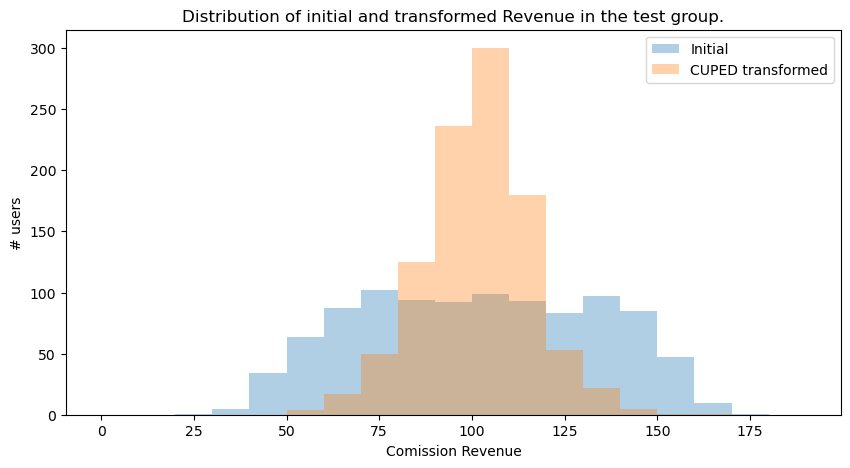

In [84]:
# visualize the new distribtuion
    # mean unchanged but variance reduced
plt.figure(figsize=(10, 5))

plt.hist(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], 
         bins=np.arange(0.0, 200.0, 10.0), 
         alpha=0.35,
         label='Initial')

plt.hist(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], 
         bins=np.arange(0.0, 200.0, 10.0), 
         alpha=0.35,
         label='CUPED transformed')

plt.legend()

plt.xlabel('Comission Revenue')
plt.ylabel('# users')

plt.title('Distribution of initial and transformed Revenue in the test group.')
plt.show();

---

## Statistical Tests: CUPED Adjusted Metric

In [97]:
# perform t-tests on experiment data, no variance correction
exp_data_test = exp_data[exp_data['group'] == 'test']
exp_data_control = exp_data[exp_data['group'] == 'control']

pg.ttest(exp_data_test['commission_revenue_exp_cuped'], exp_data_control['commission_revenue_exp_cuped'],
         correction = False).transpose()

,T-test
T,3.725796
dof,1998
alternative,two-sided
p-val,0.0002
CI95%,"[1.14, 3.68]"
cohen-d,0.166626
BF10,48.271
power,0.961137


---
**Interpretation:** 

* new p-value using the CUPED adjusted revenue is 0.0002
* decreases p-value driven by the decreases in standard error of the revenue estimate
---

## CUPED: Regression based Approach

* review regression based version to CUPED
* Intuition around how variance is being reduced
* Tutorial: https://matteocourthoud.github.io/post/cuped/

In [98]:
# From historical data
rho = 0.7  # correlation between pre and exp periods
baseline_var = 10000
mde = 50  # minimum detectable effect
alpha = 0.05
power = 0.80

# Standard sample size
from scipy.stats import norm
z_alpha = norm.ppf(1 - alpha/2)
z_beta = norm.ppf(power)
n_standard = 2 * (z_alpha + z_beta)**2 * baseline_var / mde**2

# CUPED-adjusted sample size
variance_reduction = 1 - rho**2
n_cuped = n_standard * variance_reduction

print(f"Standard sample size: {n_standard:.0f} per group")
print(f"CUPED sample size: {n_cuped:.0f} per group")
print(f"Sample size reduction: {(1 - variance_reduction)*100:.1f}%")

Standard sample size: 63 per group
CUPED sample size: 32 per group
Sample size reduction: 49.0%


In [101]:
model = smf.ols('commission_revenue_exp ~ commission_revenue_pre', data=exp_data).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     commission_revenue_exp   R-squared:                       0.790
Model:                                OLS   Adj. R-squared:                  0.790
Method:                     Least Squares   F-statistic:                     7369.
Date:                    Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                            22:22:01   Log-Likelihood:                -8000.6
No. Observations:                    1963   AIC:                         1.601e+04
Df Residuals:                        1961   BIC:                         1.602e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [102]:
smf.ols('commission_revenue_exp ~ commission_revenue_pre', data=exp_data).fit().params

Intercept                 12.660503
commission_revenue_pre     0.881830
dtype: float64

In [105]:
theta = smf.ols('commission_revenue_exp ~ commission_revenue_pre', data=exp_data).fit().params[1]
print(theta)

0.8818300441315133


/var/folders/q5/3c0wcv2n79jg6ctjb2hwph_m0000gn/T/ipykernel_55396/3105971809.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta = smf.ols('commission_revenue_exp ~ commission_revenue_pre', data=exp_data).fit().params[1]
